In [87]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sn
import warnings
import time 
warnings.filterwarnings('ignore')

In [ ]:
"""
Importing standard libraries
"""

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from google.colab import drive


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
"""
Importing libraries which will be used during creating models.
Also, I connect with my Google Drive.
"""

In [89]:
df = pd.read_csv('/content/gdrive/MyDrive/Licencjat/UrbanSound8K.csv')

sound_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
               'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

In [90]:
def cm_print(test_values, pred_values):
  cm = confusion_matrix(test_values, pred_values, normalize=None)
  plt.figure(figsize = (10,7))
  sn.heatmap(cm, annot=True, xticklabels=sound_names, yticklabels=sound_names)
  plt.xlabel('Predicted')
  plt.ylabel('Truth')

def calc_fourier(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

In [91]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
"""
We can see how the structure of .CSV file with informations about sound files looks like. 
Each file has its own folder and category.
Column "salience" means a (subjective) salience rating of the sound. 1 = foreground, 2 = background.
"""

<BarContainer object of 10 artists>

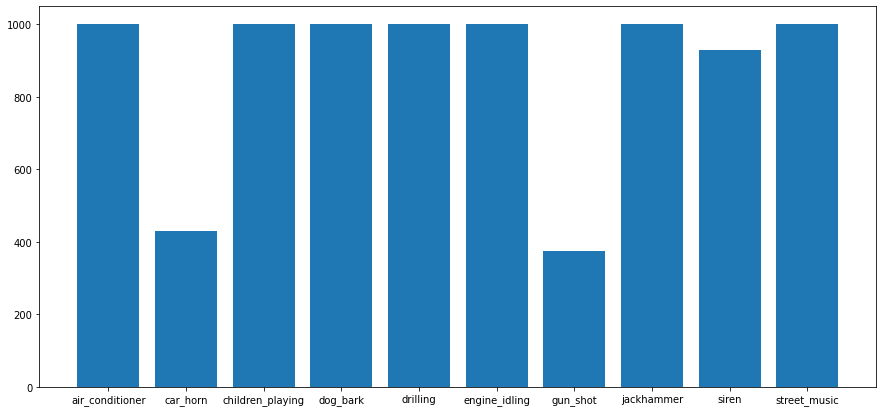

In [92]:
sound_list = list(df['classID'])
sound_counter = [sound_list.count(k) for k in range(0, len(sound_names))]

plt.figure(figsize=(15,7))
plt.bar(sound_names, sound_counter)

In [ ]:
"""
We can see that each sound appears a similar number of times, expect of car horn and gun shot.
"""

In [93]:
dat1, sampling_rate1 = librosa.load('/content/gdrive/MyDrive/Licencjat/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('/content/gdrive/MyDrive/Licencjat/fold5/100263-2-0-117.wav')

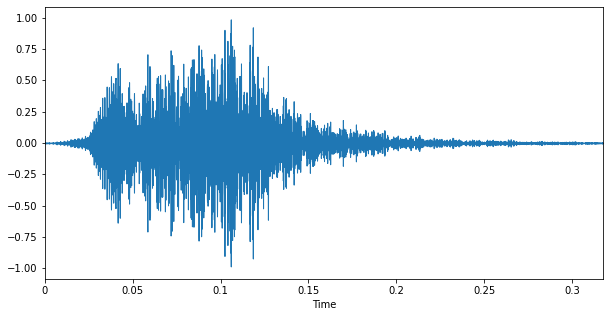

In [94]:
plt.figure(figsize=(10, 5))
librosa.display.waveplot(dat1, sr=sampling_rate1)

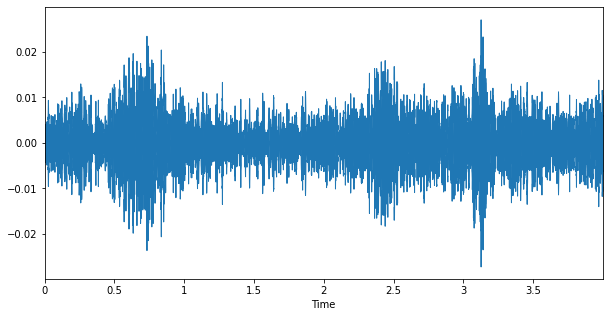

In [95]:
plt.figure(figsize=(10, 5))
librosa.display.waveplot(dat2, sr=sampling_rate2)

In [ ]:
"""
The "basic" way of presenting sounds.
"""

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

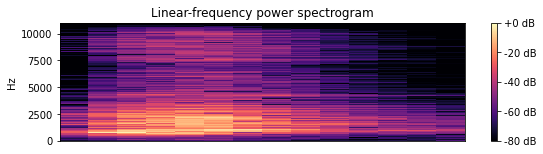

In [96]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

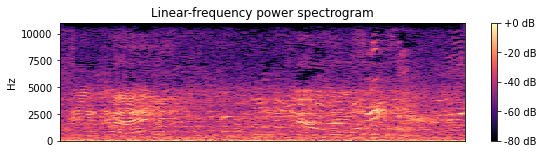

In [97]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [ ]:
"""
Presenting sounds as linear-frequency power spectograms.  
"""

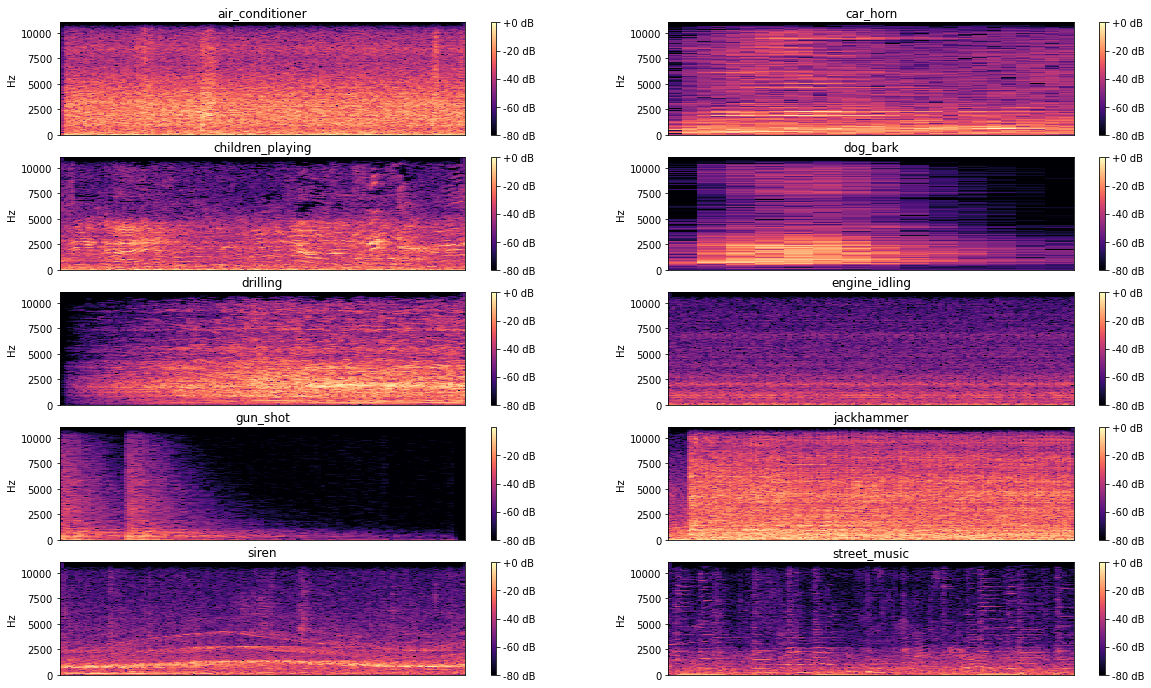

In [98]:
folders = []
file_name = []
s_rates = []
dat_all = []

for i in range(10):
  search_file = np.array(df.loc[df['classID'] == i].iloc[0])
  file_name.append(search_file[0])
  folders.append(search_file[5]) 

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,12))

for i in range(10):
  path_name = '/content/gdrive/MyDrive/Licencjat/fold' +  str(folders[i]) +  '/' + str(file_name[i])
  dat, sampling_rate = librosa.load(path_name)

  dat_all.append(dat)
  s_rates.append(sampling_rate)

  plt.subplot(5,2,i+1)
  D = librosa.amplitude_to_db(np.abs(librosa.stft(dat)), ref=np.max)
  librosa.display.specshow(D, y_axis='linear')
  plt.colorbar(format='%+2.0f dB')
  plt.title(sound_names[i])

In [ ]:
"""
Presentation of sounds of each category as spectograms.
We can observe that practically each of the sounds isn't very similar to each other.  
This is a good starting point for creating models.
"""

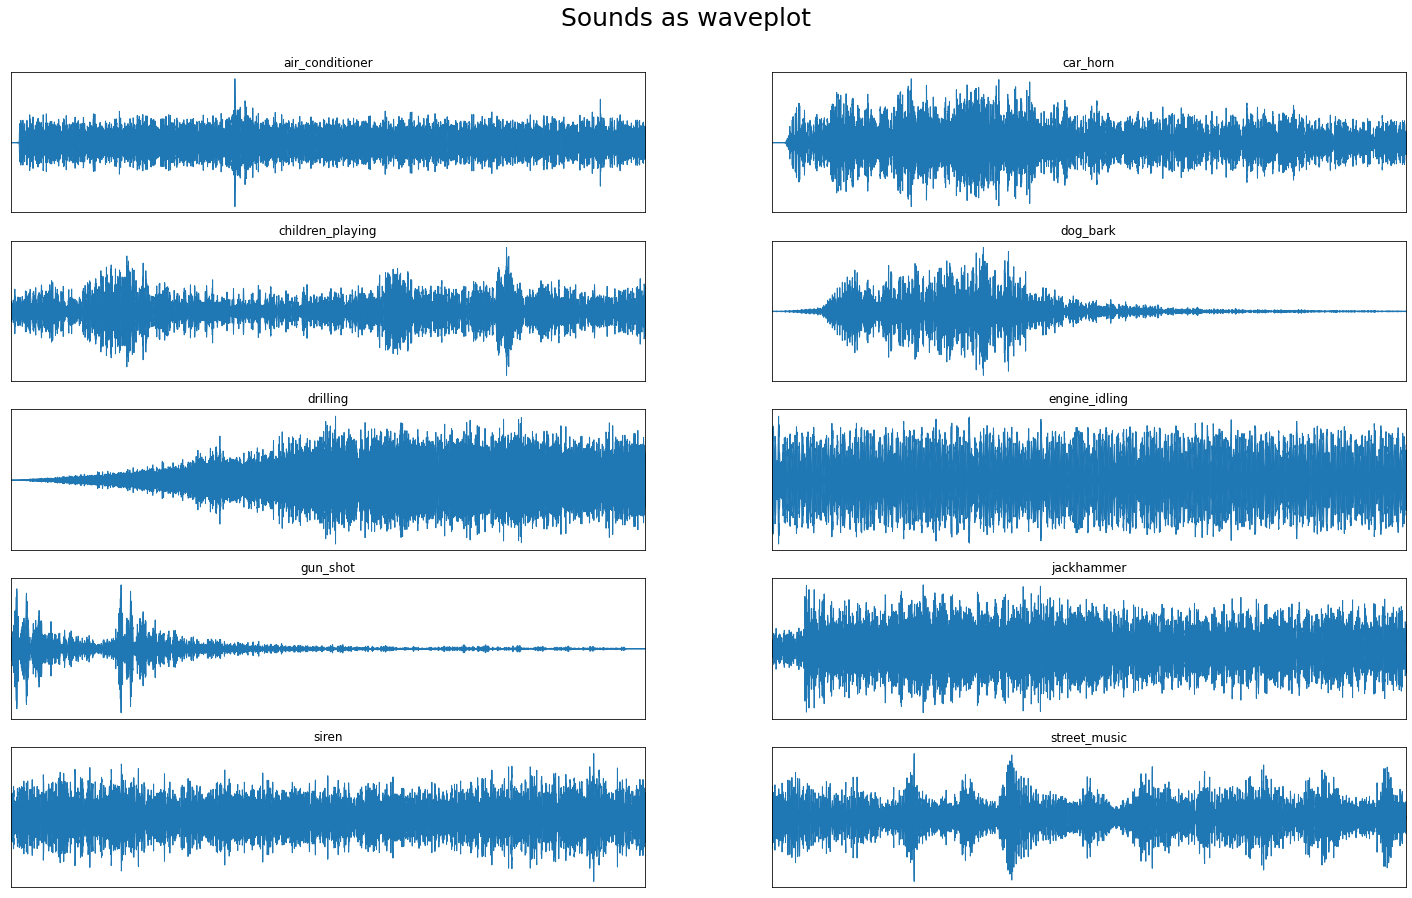

In [99]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=False,
                             sharey=False, figsize=(25,15))
fig.suptitle('Sounds as waveplot', size=25, y=0.94)

for i in range(0, 10):
  plt.subplot(5,2,i+1)
  librosa.display.waveplot(dat_all[i], sr=s_rates[i])
  plt.subplot(5,2,i+1).get_xaxis().set_visible(False)
  plt.subplot(5,2,i+1).get_yaxis().set_visible(False) 
  plt.title(sound_names[i])


In [ ]:
"""
Presentation of sounds of each category.
We can notice that there are some sounds which "look" very similar, like engine idling and jackhammer or air conditioner and siren.
On the other side, gun shot and dog bark look quite different from the rest.
"""

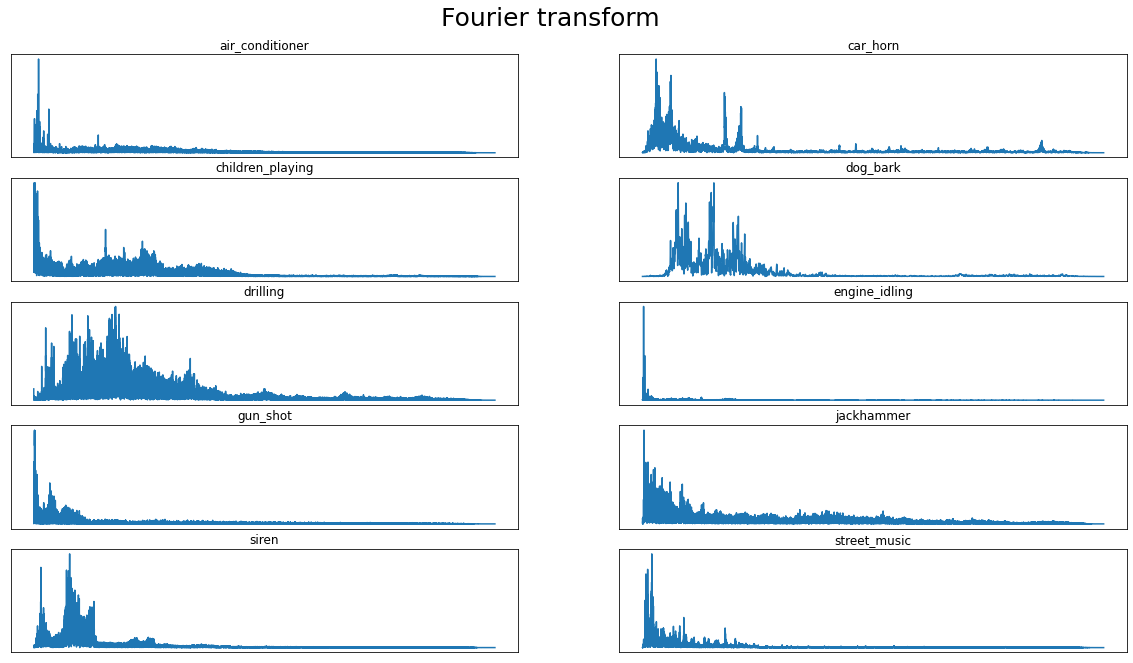

In [100]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=False,
                             sharey=False, figsize=(20, 11))
fig.suptitle('Fourier transform', size=25, y=0.94)

for i in range(0, 10):
  plt.subplot(5,2,i+1)
  y, rate = calc_fourier(dat_all[i], s_rates[i])
  plt.plot(rate, y)
  plt.subplot(5,2,i+1).get_xaxis().set_visible(False)
  plt.subplot(5,2,i+1).get_yaxis().set_visible(False) 
  plt.title(sound_names[i])



In [ ]:
"""
Short Time Fourier Transform (STFT) of the signals using the Fast Fourier Transform (FFT) algorithm.
The results are the periodograms, with the y axis representing the power and the x axis representing frequency.
Interestingly, when engine idling and jackhammer or air conditioner and siren look similarly in the waveplot presentation, 
their Fourier presentations look different and it is hard to say that they look similarly.
"""

In [ ]:
"""
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in range(8732):
        file_name = '/content/gdrive/MyDrive/Licencjat/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

temp = parser(df)

temp = np.array(temp)
data = temp.transpose()

X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

for i in range(8732):
    X[i] = (X_[i])

from tensorflow.keras.utils import to_categorical 
Y = to_categorical(Y)

mee = pd.DataFrame(X)
tee = pd.DataFrame(Y)

mee.to_csv('/content/gdrive/MyDrive/Licencjat/X.csv', index=False)
tee.to_csv('/content/gdrive/MyDrive/Licencjat/Y.csv', index=False)
"""

In [ ]:
"""
This piece of code was used to extract the spectrogram data as a numpy array of each sound file.
After that I saved these arrays as X and Y on my Google Drive. 
"""

In [101]:
X = pd.read_csv('/content/gdrive/MyDrive/Licencjat/X.csv')
Y = pd.read_csv('/content/gdrive/MyDrive/Licencjat/Y.csv')

In [ ]:
"""
Loading data from Google Drive.
"""

In [102]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.000027,0.000222,0.000300,0.000559,0.000498,0.001092,0.005211,0.003607,0.003064,0.001188,0.000744,0.001553,0.001686,0.001788,0.003083,0.009207,0.006609,0.004827,0.015548,0.042405,0.109497,0.342492,0.282805,0.374673,1.728140,6.562219,2.733233,4.238861,5.818360,11.887260,35.526623,42.419613,57.577229,17.555015,11.393781,14.548044,8.217465,5.471920,17.871936,39.071403,...,0.029233,0.012889,0.011059,0.019688,0.072233,0.044574,0.013832,0.008721,0.005157,0.005339,0.002593,0.002175,0.003774,0.003206,0.003679,0.003959,0.003521,0.006161,0.004220,0.002385,0.003809,0.001870,0.001239,0.001552,0.002020,0.007422,0.038494,0.014019,0.005995,1.094872e-02,9.922590e-03,1.117456e-02,9.358009e-03,3.954219e-03,2.508323e-03,6.515521e-04,4.807037e-04,2.130472e-04,8.369143e-06,6.568746e-07
1,0.049703,0.049530,0.037174,0.028718,0.012635,0.006106,0.004149,0.003606,0.002432,0.002100,0.003036,0.003517,0.003066,0.003065,0.003250,0.003259,0.001729,0.001239,0.001162,0.001416,0.001363,0.001928,0.001804,0.001528,0.001831,0.001249,0.000827,0.000572,0.000409,0.000682,0.000987,0.000980,0.001318,0.001508,0.001803,0.000897,0.000600,0.000625,0.000515,0.000927,...,0.000700,0.001092,0.000975,0.000627,0.000578,0.000426,0.000285,0.000287,0.000277,0.000133,0.000056,0.000035,0.000021,0.000013,0.000012,0.000014,0.000015,0.000008,0.000008,0.000007,0.000007,0.000008,0.000007,0.000006,0.000007,0.000007,0.000005,0.000005,0.000005,5.073589e-06,9.408279e-06,1.175539e-05,2.637385e-06,2.653793e-06,1.477016e-06,3.809359e-07,1.498473e-07,3.523647e-08,1.270208e-08,6.447204e-09
2,0.030851,0.028022,0.036446,0.025970,0.009835,0.005249,0.004420,0.002599,0.002228,0.002284,0.002161,0.002497,0.003196,0.003391,0.002135,0.000817,0.000738,0.000804,0.000674,0.000830,0.000687,0.000514,0.000517,0.000448,0.000756,0.000638,0.000863,0.000570,0.000278,0.000226,0.000231,0.000191,0.000269,0.000320,0.000843,0.001022,0.001379,0.001450,0.001990,0.003643,...,0.000220,0.000196,0.000142,0.000198,0.000164,0.000132,0.000095,0.000066,0.000034,0.000023,0.000020,0.000015,0.000010,0.000009,0.000012,0.000007,0.000003,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001,9.772823e-07,8.826517e-07,8.600000e-07,8.267793e-07,5.027458e-07,2.654876e-07,1.374288e-07,5.228368e-08,1.578363e-08,4.880092e-09,2.650197e-09
3,0.026513,0.032829,0.045829,0.032968,0.058508,0.028729,0.005424,0.004886,0.004273,0.003869,0.002937,0.003220,0.005218,0.003804,0.004220,0.007543,0.015745,0.013699,0.012117,0.029302,0.028676,0.014435,0.006776,0.012512,0.014645,0.003567,0.001010,0.000756,0.001086,0.001852,0.002264,0.003295,0.002156,0.001171,0.000736,0.000991,0.001806,0.000982,0.000948,0.006395,...,0.001212,0.000568,0.000359,0.000681,0.000516,0.001038,0.001320,0.000907,0.001053,0.000843,0.000645,0.000221,0.000096,0.000021,0.000018,0.000014,0.000015,0.000013,0.000038,0.000047,0.000032,0.000039,0.000019,0.000033,0.000031,0.000021,0.000016,0.000015,0.000017,2.224763e-05,1.914494e-05,1.215152e-05,1.265005e-05,5.911242e-06,2.883501e-06,2.177644e-06,1.631104e-06,3.138977e-07,5.940740e-08,4.145751e-09
4,0.061545,0.040471,0.023154,0.015849,0.013775,0.006138,0.005036,0.003236,0.002585,0.002473,0.002194,0.002847,0.002772,0.001959,0.001577,0.001193,0.000999,0.000674,0.000710,0.000824,0.000929,0.000763,0.000420,0.000504,0.000641,0.000400,0.000278,0.000294,0.000341,0.000313,0.000251,0.000202,0.000282,0.000357,0.000374,0.000658,0.001298,0.002484,0.002337,0.000927,...,0.000334,0.000375,0.000303,0.000349,0.000386,0.000276,0.000176,0.000132,0.000101,0.000041,0.000019,0.000015,0.000013,0.000011,0.000011,0.000010,0.000007,0.000006,0.000004,0.000004,0.000003,0.000003,0.000003,0.000003,0.000002,0.000001,0.000001,0.000002,0.000001,1.330523e-06,1.122392

In [ ]:
"""
Each sound has 128 "features". 
"""

In [103]:
Y

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
8727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8728,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8729,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8730,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
"""
"1" in the column means which classID the sound has (One Hot Encoding).
"""

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 1)

In [105]:
X_train.shape

(6112, 128)

In [106]:
y_train_hot = []
y_test_hot = []
time_measures = []
score_measures = []

for i in range(0, X_train.shape[0]):
  new_features = np.array(Y_train.iloc[i,:])
  y_train_hot.append(str(np.argmax(new_features)))
y_train_hot = np.array(y_train_hot)

for i in range(0, X_test.shape[0]):
  new_features = np.array(Y_test.iloc[i,:])
  y_test_hot.append(str(np.argmax(new_features)))
y_test_hot = np.array(y_test_hot)

In [ ]:
"""
Creating the list with indexes of each sound in Y.
"""

In [107]:
lr = LogisticRegression(multi_class='ovr')

start = time.time()

lr.fit(X_train, y_train_hot)

end = time.time()
times_measures.append(end-start)

In [108]:
score_measures.append(lr.score(X_test, y_test_hot))
score_measures[0]

0.4125954198473282

In [ ]:
"""
Score is quite low.
"""

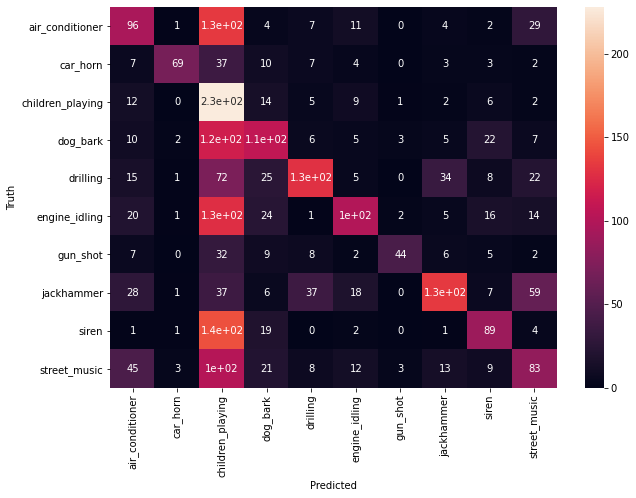

In [109]:
y_pred = lr.predict(X_test)
cm_print(y_test_hot, y_pred)

In [ ]:
"""
There are many misclassified sounds. 
The model has the biggest problem with classifying the sounds of "children playing".
Air conditioner and street music aren't easy either.
"""

In [110]:
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=100,
                                random_state=42,
                                n_jobs=1)

In [111]:
start = time.time()

forest.fit(X_train, y_train_hot)

end = time.time()
times_measures.append(end-start)

In [112]:
score_measures.append(forest.score(X_test, y_test_hot))
score_measures[1]

0.8599236641221374

In [ ]:
"""
Score is very high, more than 2 times higher than the Logistic Regression model.
"""

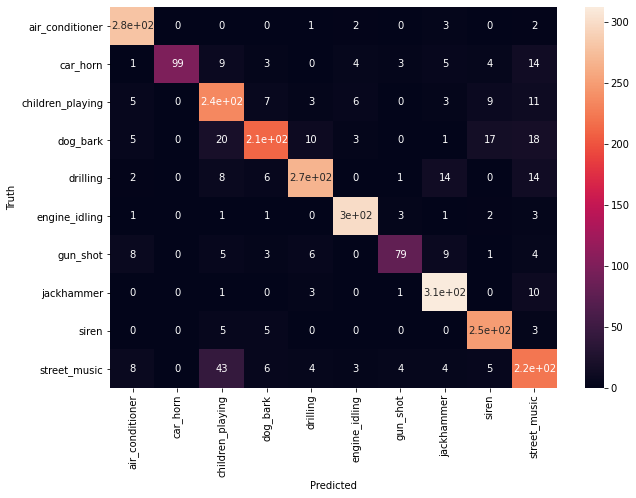

In [113]:
y_pred = forest.predict(X_test)
cm_print(y_test_hot, y_pred)

In [ ]:
"""
Confusion matrix looks very "clear".
That model had the biggest problem with "children playing" and "street music" either.
"""

In [114]:
svm = SVC(kernel='poly', decision_function_shape='ovr', gamma=0.001,C=1000)

svm.fit(X_train, y_train_hot)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [115]:
svm.score(X_test, y_test_hot)

0.5248091603053435

In [ ]:
"""
Not satisfied score.
"""

In [116]:
svm = SVC( kernel='rbf', decision_function_shape='ovr', gamma=0.001,C=1000)

start = time.time()

svm.fit(X_train, y_train_hot)

end = time.time()
times_measures.append(end-start)

In [117]:
score_measures.append(svm.score(X_train, y_train_hot))
score_measures[2]

0.8604384816753927

In [ ]:
"""
Changing the "kernel" increased the score by 0.3!
The score is very similar to Random Forest score.
"""

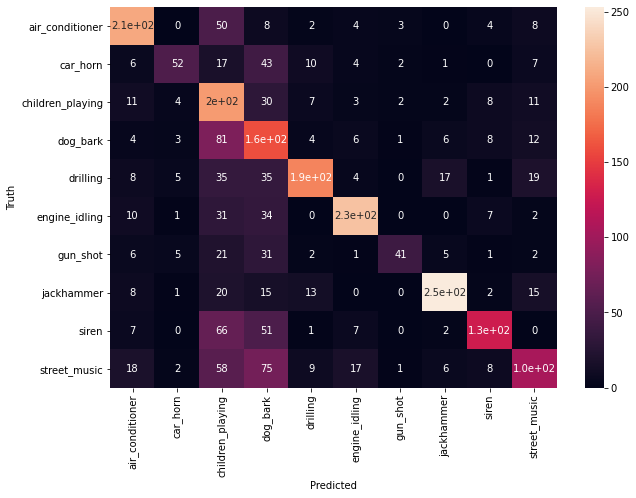

In [118]:
y_pred = svm.predict(X_test)
cm_print(y_test_hot, y_pred)

In [ ]:
"""
The model had the biggest problem with "children playing" either BUT...
this time on the second place was "dog bark". Other models had had problems with it either but never high like this one. 
"""

In [119]:
knn = KNeighborsClassifier(n_neighbors=2,
                           p=1,
                           metric='minkowski')

start = time.time()

knn.fit(X_train, y_train_hot)

end = time.time()
times_measures.append(end-start)

In [120]:
score_measures.append(knn.score(X_test, y_test_hot))
score_measures[3]

0.767557251908397

In [ ]:
"""
A quite good score.
"""

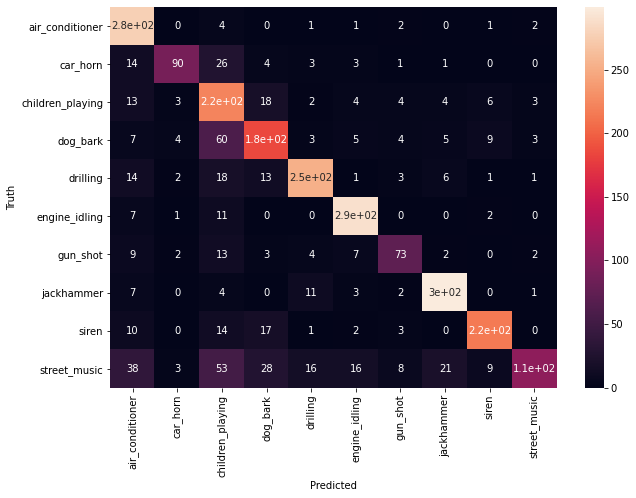

In [121]:
y_pred = knn.predict(X_test)
cm_print(y_test_hot, y_pred)

In [ ]:
"""
Again, the model had the biggest problem with "children playing".
This time the model has classified "dog bark" a quite well, but had more problems with air conditioner. 
"""

In [ ]:
"""
To sum up, each model works differently, so each makes mistakes specified for itself.
"""

In [122]:
summary_df = {'LR': [times_measures[0], score_measures[0]], 'RFC': [times_measures[1], score_measures[1]], 
              'SVC': [times_measures[2], score_measures[2]], 'KNN': [times_measures[3], score_measures[3]]}
summary_df = pd.DataFrame(summary_df)
summary_df.index = ['Time', 'Score']
summary_df

,LR,RFC,SVC,KNN
Time,2.171241,23.787457,10.303981,0.097108
Score,0.412595,0.859924,0.860438,0.767557


In [ ]:
"""
It's seems that SVC was the best choice, looking the time measure and the score.
However, KNeighborsClassifier also deserved our attention, because it got a pretty good result and only needed 0.09 sec for it!  
"""